In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.losses import  binary_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,
                         sparse_recon_loss_mse, make_sparse_recon_loss_var)

from Autoencoders import autoencoder

from general_loader import ds_from_db
from data_manipulation import remove_outlier, augment_x_linear,augment_x,split_data_X_Y
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.initializers import glorot_normal


/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from gan_nw_2 import generator_nw_5,discriminator_nw,gan_nw, discriminator_nw_4
from gan_utils import Discrim_pre_train, train_for_n, plot_loss, train_for_n_mono

In [3]:
ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [4]:
X,Y,idx,cols=split_data_X_Y(ds.FT.replace([np.inf, -np.inf], np.nan),['Revenues'])
XY,idx=remove_outlier(np.concatenate((X,Y),axis=1),2.5,Y=idx,y_thresh=True)
X[np.isnan(X)]=0

#dump zero y rows
tf=XY[:,200]!=0
XY=XY[tf]
idx=idx[tf]

#check there is at least one dp for every record
assert all(np.sum(XY!=0,axis=1)>0)



amal_train,amal_test,idx_train,idx_test=train_test_split(XY,idx,test_size=0.25,random_state=30)
x_train=amal_train[:,0:199]
x_test=amal_test[:,0:199]
y_test=amal_test[:,200].reshape((x_test.shape[0],1))
y_train=amal_train[:,200].reshape((x_train.shape[0],1))

/home/anywayed/Documents/dis/secTools/data_manipulation.py:32: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [5]:
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='sparse_recon_loss_combi_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')


train_dic={
           'epochs':100,'batch_size':128
          }

In [6]:
ker_init=glorot_normal(seed=22)
layer_p_dic={'drop_ra':0.1, 'g_noise':0.05, 'ker_init':ker_init}
nodes=[32,16,4,16,32]

In [7]:
pre_gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
pre_train_ae=generator_nw_5(x_train,**layer_p_dic,nodes=nodes,y=True)
pre_train_ae.compile(**pre_gen_compile_dic)
pre_x_train=np.concatenate((x_train,y_train),axis=1)
pre_x_test=np.concatenate((x_test,y_test),axis=1)
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
pre_train_ae.fit([x_train,y_train],pre_x_train,validation_data=([x_test,y_test], pre_x_test),
                 epochs=50,batch_size=128,callbacks=[ES])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_1[0][0]              
__________

2339/2339 [==============================] - 0s 45us/step - loss: 0.0673 - sparse_recon_loss_mse: 0.0559 - sparse_recon_loss_abs: 0.1127 - sparse_recon_loss_var: 0.0879 - val_loss: 0.0649 - val_sparse_recon_loss_mse: 0.0531 - val_sparse_recon_loss_abs: 0.1121 - val_sparse_recon_loss_var: 0.0843
Epoch 12/50
2339/2339 [==============================] - 0s 45us/step - loss: 0.0655 - sparse_recon_loss_mse: 0.0543 - sparse_recon_loss_abs: 0.1105 - sparse_recon_loss_var: 0.0861 - val_loss: 0.0634 - val_sparse_recon_loss_mse: 0.0517 - val_sparse_recon_loss_abs: 0.1101 - val_sparse_recon_loss_var: 0.0828
Epoch 13/50
2339/2339 [==============================] - 0s 45us/step - loss: 0.0651 - sparse_recon_loss_mse: 0.0540 - sparse_recon_loss_abs: 0.1097 - sparse_recon_loss_var: 0.0865 - val_loss: 0.0626 - val_sparse_recon_loss_mse: 0.0510 - val_sparse_recon_loss_abs: 0.1092 - val_sparse_recon_loss_var: 0.0819
Epoch 14/50
2339/2339 [==============================] - 0s 43us/step - loss: 0.0640 - s

Epoch 38/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0554 - sparse_recon_loss_mse: 0.0444 - sparse_recon_loss_abs: 0.0993 - sparse_recon_loss_var: 0.0744 - val_loss: 0.0525 - val_sparse_recon_loss_mse: 0.0418 - val_sparse_recon_loss_abs: 0.0954 - val_sparse_recon_loss_var: 0.0722
Epoch 39/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0555 - sparse_recon_loss_mse: 0.0446 - sparse_recon_loss_abs: 0.0991 - sparse_recon_loss_var: 0.0763 - val_loss: 0.0522 - val_sparse_recon_loss_mse: 0.0415 - val_sparse_recon_loss_abs: 0.0948 - val_sparse_recon_loss_var: 0.0722
Epoch 40/50
2339/2339 [==============================] - 0s 41us/step - loss: 0.0550 - sparse_recon_loss_mse: 0.0442 - sparse_recon_loss_abs: 0.0984 - sparse_recon_loss_var: 0.0743 - val_loss: 0.0517 - val_sparse_recon_loss_mse: 0.0410 - val_sparse_recon_loss_abs: 0.0943 - val_sparse_recon_loss_var: 0.0719
Epoch 41/50
2339/2339 [==============================] - 0s 41us/step - loss

In [8]:
weights=pre_train_ae.get_weights()

In [19]:
gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
Generator=generator_nw_5(x_train,**layer_p_dic,nodes=nodes,y=True)
Generator.compile(**gen_compile_dic)
Generator.set_weights(weights)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_5[0][0]              
__________

In [18]:
dis_compile_dic={'loss':binary_crossentropy,'optimizer':Adam(lr=0.001)} #'early_stop':ES}
layer_p_dic={'drop_ra':0.05, 'g_noise':0.05, 'ker_init':ker_init}
Discrim=discriminator_nw_4(x_train,**layer_p_dic,nodes=[64,40,28,16])
Discrim.compile(**dis_compile_dic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_RealorFake (InputLayer)    (None, 200)               0         
_________________________________________________________________
H1_dropout (Dropout)         (None, 200)               0         
_________________________________________________________________
H1_noise (GaussianNoise)     (None, 200)               0         
_________________________________________________________________
dH1_layer (Dense)            (None, 64)                12864     
_________________________________________________________________
dH1_activation (PReLU)       (None, 64)                64        
_________________________________________________________________
dH2_dropout (Dropout)        (None, 64)                0         
_________________________________________________________________
dH2_noise (GaussianNoise)    (None, 64)                0         
__________

In [20]:
XT_aug, y_hat=Discrim_pre_train(x_train,y_train,Discrim,train_size=1000)

(2000, 200)
Epoch 1/10
2000/2000 [==============================] - 1s 658us/step - loss: 0.3425
Epoch 2/10
2000/2000 [==============================] - 0s 87us/step - loss: 0.0298
Epoch 3/10
2000/2000 [==============================] - 0s 90us/step - loss: 0.0087
Epoch 4/10
2000/2000 [==============================] - 0s 90us/step - loss: 0.0054
Epoch 5/10
2000/2000 [==============================] - 0s 88us/step - loss: 0.0032
Epoch 6/10
2000/2000 [==============================] - 0s 90us/step - loss: 0.0018
Epoch 7/10
2000/2000 [==============================] - 0s 86us/step - loss: 9.8019e-04
Epoch 8/10
2000/2000 [==============================] - 0s 88us/step - loss: 9.6520e-04
Epoch 9/10
2000/2000 [==============================] - 0s 88us/step - loss: 0.0017
Epoch 10/10
2000/2000 [==============================] - 0s 89us/step - loss: 9.6830e-04
Accuracy: 100.0 % 2000  of  2000 correct


In [21]:
gan_compile_dic={'loss':[loss,binary_crossentropy],'optimizer':Adam(lr=0.001)}
GAN=gan_nw(Generator,Discrim,x_train)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 199)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 200)          10767       input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            16274       model_6[1][0]                    
Total para

In [22]:
train_dic={'x_train':x_train,'y_train':y_train,'x_test':x_test,'y_test':y_test,
'nb_epoch':1000,'plt_frq':100,'batch_size':128,'test_size':64,'Generator':Generator,
'Discriminator':Discrim,'GAN':GAN,'plot':False,'weight_change':True,'alpha':5,'gan_compile_dic':gan_compile_dic,
          'real_smoothing':0.95}

In [23]:
out_dic=train_for_n_mono(**train_dic)

  0%|          | 0/1000 [00:00<?, ?it/s]

64/64 [==============================] - 0s 47us/step


  0%|          | 1/1000 [00:04<1:21:28,  4.89s/it]

64/64 [==============================] - 0s 45us/step


  0%|          | 4/1000 [00:04<20:43,  1.25s/it]  

64/64 [==============================] - 0s 59us/step


  1%|          | 8/1000 [00:05<10:33,  1.57it/s]

64/64 [==============================] - 0s 48us/step


  1%|          | 12/1000 [00:05<07:10,  2.29it/s]

64/64 [==============================] - 0s 61us/step


  2%|▏         | 16/1000 [00:05<05:29,  2.99it/s]

64/64 [==============================] - 0s 61us/step


  2%|▏         | 20/1000 [00:05<04:28,  3.64it/s]

64/64 [==============================] - 0s 51us/step


  2%|▏         | 24/1000 [00:05<03:48,  4.28it/s]

64/64 [==============================] - 0s 59us/step


  3%|▎         | 28/1000 [00:05<03:19,  4.88it/s]

64/64 [==============================] - 0s 43us/step


  3%|▎         | 32/1000 [00:05<02:56,  5.47it/s]

64/64 [==============================] - 0s 40us/step


  4%|▎         | 36/1000 [00:05<02:39,  6.04it/s]

64/64 [==============================] - 0s 57us/step


  4%|▍         | 40/1000 [00:06<02:25,  6.59it/s]

64/64 [==============================] - 0s 117us/step


  4%|▍         | 44/1000 [00:06<02:14,  7.11it/s]

64/64 [==============================] - 0s 56us/step


  5%|▍         | 48/1000 [00:06<02:04,  7.62it/s]

64/64 [==============================] - 0s 57us/step


  5%|▌         | 52/1000 [00:06<01:56,  8.11it/s]

64/64 [==============================] - 0s 53us/step


  6%|▌         | 56/1000 [00:06<01:50,  8.58it/s]

64/64 [==============================] - 0s 51us/step


  6%|▌         | 60/1000 [00:06<01:44,  9.03it/s]

64/64 [==============================] - 0s 65us/step


  6%|▋         | 64/1000 [00:06<01:38,  9.47it/s]

64/64 [==============================] - 0s 70us/step


  7%|▋         | 68/1000 [00:06<01:34,  9.90it/s]

64/64 [==============================] - 0s 62us/step


  7%|▋         | 72/1000 [00:06<01:30, 10.31it/s]

64/64 [==============================] - 0s 43us/step


  8%|▊         | 76/1000 [00:07<01:26, 10.69it/s]

64/64 [==============================] - 0s 42us/step


  8%|▊         | 80/1000 [00:07<01:23, 11.07it/s]

64/64 [==============================] - 0s 51us/step


  8%|▊         | 84/1000 [00:07<01:19, 11.45it/s]

64/64 [==============================] - 0s 61us/step


  9%|▉         | 88/1000 [00:07<01:17, 11.80it/s]

64/64 [==============================] - 0s 62us/step


  9%|▉         | 92/1000 [00:07<01:14, 12.16it/s]

64/64 [==============================] - 0s 42us/step


 10%|▉         | 96/1000 [00:07<01:12, 12.50it/s]

64/64 [==============================] - 0s 66us/step


 10%|█         | 100/1000 [00:07<01:10, 12.83it/s]

64/64 [==============================] - 0s 57us/step


 10%|█         | 104/1000 [00:10<01:34,  9.52it/s]

64/64 [==============================] - 0s 72us/step


 11%|█         | 108/1000 [00:11<01:31,  9.79it/s]

64/64 [==============================] - 0s 60us/step


 11%|█         | 112/1000 [00:11<01:28, 10.04it/s]

64/64 [==============================] - 0s 66us/step


 12%|█▏        | 116/1000 [00:11<01:25, 10.29it/s]

64/64 [==============================] - 0s 53us/step


 12%|█▏        | 120/1000 [00:11<01:23, 10.54it/s]

64/64 [==============================] - 0s 50us/step


 12%|█▏        | 124/1000 [00:11<01:21, 10.78it/s]

64/64 [==============================] - 0s 96us/step


 13%|█▎        | 128/1000 [00:11<01:19, 10.99it/s]

64/64 [==============================] - 0s 51us/step


 13%|█▎        | 132/1000 [00:11<01:17, 11.22it/s]

64/64 [==============================] - 0s 76us/step


 14%|█▎        | 136/1000 [00:11<01:15, 11.45it/s]

64/64 [==============================] - 0s 48us/step


 14%|█▍        | 140/1000 [00:11<01:13, 11.67it/s]

64/64 [==============================] - 0s 47us/step


 14%|█▍        | 144/1000 [00:12<01:12, 11.89it/s]

64/64 [==============================] - 0s 55us/step


 15%|█▍        | 148/1000 [00:12<01:10, 12.10it/s]

64/64 [==============================] - 0s 60us/step


 15%|█▌        | 152/1000 [00:12<01:08, 12.31it/s]

64/64 [==============================] - 0s 67us/step


 16%|█▌        | 156/1000 [00:12<01:07, 12.52it/s]

64/64 [==============================] - 0s 46us/step


 16%|█▌        | 160/1000 [00:12<01:05, 12.73it/s]

64/64 [==============================] - 0s 54us/step


 16%|█▋        | 164/1000 [00:12<01:04, 12.93it/s]

64/64 [==============================] - 0s 48us/step


 17%|█▋        | 168/1000 [00:12<01:03, 13.13it/s]

64/64 [==============================] - 0s 83us/step


 17%|█▋        | 172/1000 [00:12<01:02, 13.32it/s]

64/64 [==============================] - 0s 64us/step


 18%|█▊        | 176/1000 [00:13<01:01, 13.51it/s]

64/64 [==============================] - 0s 54us/step


 18%|█▊        | 180/1000 [00:13<00:59, 13.69it/s]

64/64 [==============================] - 0s 48us/step


 18%|█▊        | 184/1000 [00:13<00:58, 13.88it/s]

64/64 [==============================] - 0s 54us/step


 19%|█▉        | 188/1000 [00:13<00:57, 14.05it/s]

64/64 [==============================] - 0s 69us/step


 19%|█▉        | 192/1000 [00:13<00:56, 14.23it/s]

64/64 [==============================] - 0s 71us/step


 20%|█▉        | 196/1000 [00:13<00:55, 14.41it/s]

64/64 [==============================] - 0s 48us/step


 20%|██        | 200/1000 [00:13<00:54, 14.58it/s]

64/64 [==============================] - 0s 59us/step


 20%|██        | 204/1000 [00:16<01:05, 12.10it/s]

64/64 [==============================] - 0s 66us/step


 21%|██        | 208/1000 [00:16<01:04, 12.25it/s]

64/64 [==============================] - 0s 48us/step


 21%|██        | 212/1000 [00:17<01:03, 12.40it/s]

64/64 [==============================] - 0s 59us/step


 22%|██▏       | 216/1000 [00:17<01:02, 12.55it/s]

64/64 [==============================] - 0s 51us/step


 22%|██▏       | 220/1000 [00:17<01:01, 12.69it/s]

64/64 [==============================] - 0s 60us/step


 22%|██▏       | 224/1000 [00:17<01:00, 12.83it/s]

64/64 [==============================] - 0s 46us/step


 23%|██▎       | 228/1000 [00:17<00:59, 12.98it/s]

64/64 [==============================] - 0s 59us/step


 23%|██▎       | 232/1000 [00:17<00:58, 13.12it/s]

64/64 [==============================] - 0s 50us/step


 24%|██▎       | 236/1000 [00:17<00:57, 13.26it/s]

64/64 [==============================] - 0s 68us/step


 24%|██▍       | 240/1000 [00:17<00:56, 13.38it/s]

64/64 [==============================] - 0s 41us/step


 24%|██▍       | 244/1000 [00:18<00:55, 13.51it/s]

64/64 [==============================] - 0s 48us/step


 25%|██▍       | 248/1000 [00:18<00:55, 13.65it/s]

64/64 [==============================] - 0s 56us/step


 25%|██▌       | 252/1000 [00:18<00:54, 13.78it/s]

64/64 [==============================] - 0s 47us/step


 26%|██▌       | 256/1000 [00:18<00:53, 13.91it/s]

64/64 [==============================] - 0s 58us/step


 26%|██▌       | 260/1000 [00:18<00:52, 14.04it/s]

64/64 [==============================] - 0s 63us/step


 26%|██▋       | 264/1000 [00:18<00:51, 14.17it/s]

64/64 [==============================] - 0s 48us/step


 27%|██▋       | 268/1000 [00:18<00:51, 14.29it/s]

64/64 [==============================] - 0s 53us/step


 27%|██▋       | 272/1000 [00:18<00:50, 14.41it/s]

64/64 [==============================] - 0s 68us/step


 28%|██▊       | 276/1000 [00:18<00:49, 14.53it/s]

64/64 [==============================] - 0s 46us/step


 28%|██▊       | 280/1000 [00:19<00:49, 14.65it/s]

64/64 [==============================] - 0s 43us/step


 28%|██▊       | 284/1000 [00:19<00:48, 14.76it/s]

64/64 [==============================] - 0s 69us/step


 29%|██▉       | 288/1000 [00:19<00:47, 14.88it/s]

64/64 [==============================] - 0s 45us/step


 29%|██▉       | 292/1000 [00:19<00:47, 15.00it/s]

64/64 [==============================] - 0s 60us/step


 30%|██▉       | 296/1000 [00:19<00:46, 15.11it/s]

64/64 [==============================] - 0s 49us/step


 30%|███       | 300/1000 [00:19<00:45, 15.22it/s]

64/64 [==============================] - 0s 52us/step


 30%|███       | 304/1000 [00:22<00:52, 13.23it/s]

64/64 [==============================] - 0s 68us/step


 31%|███       | 308/1000 [00:23<00:51, 13.34it/s]

64/64 [==============================] - 0s 62us/step


 31%|███       | 312/1000 [00:23<00:51, 13.44it/s]

64/64 [==============================] - 0s 75us/step


 32%|███▏      | 316/1000 [00:23<00:50, 13.55it/s]

64/64 [==============================] - 0s 45us/step


 32%|███▏      | 320/1000 [00:23<00:49, 13.65it/s]

64/64 [==============================] - 0s 53us/step


 32%|███▏      | 324/1000 [00:23<00:49, 13.75it/s]

64/64 [==============================] - 0s 47us/step


 33%|███▎      | 328/1000 [00:23<00:48, 13.85it/s]

64/64 [==============================] - 0s 80us/step


 33%|███▎      | 332/1000 [00:23<00:47, 13.94it/s]

64/64 [==============================] - 0s 50us/step


 34%|███▎      | 336/1000 [00:23<00:47, 14.04it/s]

64/64 [==============================] - 0s 66us/step


 34%|███▍      | 340/1000 [00:24<00:46, 14.14it/s]

64/64 [==============================] - 0s 80us/step


 34%|███▍      | 344/1000 [00:24<00:46, 14.24it/s]

64/64 [==============================] - 0s 60us/step


 35%|███▍      | 348/1000 [00:24<00:45, 14.33it/s]

64/64 [==============================] - 0s 46us/step


 35%|███▌      | 352/1000 [00:24<00:44, 14.43it/s]

64/64 [==============================] - 0s 58us/step


 36%|███▌      | 356/1000 [00:24<00:44, 14.52it/s]

64/64 [==============================] - 0s 57us/step


 36%|███▌      | 360/1000 [00:24<00:43, 14.61it/s]

64/64 [==============================] - 0s 77us/step


 36%|███▋      | 364/1000 [00:24<00:43, 14.70it/s]

64/64 [==============================] - 0s 68us/step


 37%|███▋      | 368/1000 [00:24<00:42, 14.79it/s]

64/64 [==============================] - 0s 68us/step


 37%|███▋      | 372/1000 [00:24<00:42, 14.89it/s]

64/64 [==============================] - 0s 47us/step


 38%|███▊      | 376/1000 [00:25<00:41, 14.98it/s]

64/64 [==============================] - 0s 46us/step


 38%|███▊      | 380/1000 [00:25<00:41, 15.07it/s]

64/64 [==============================] - 0s 58us/step


 38%|███▊      | 384/1000 [00:25<00:40, 15.15it/s]

64/64 [==============================] - 0s 42us/step


 39%|███▉      | 388/1000 [00:25<00:40, 15.24it/s]

64/64 [==============================] - 0s 51us/step


 39%|███▉      | 392/1000 [00:25<00:39, 15.32it/s]

64/64 [==============================] - 0s 52us/step


 40%|███▉      | 396/1000 [00:25<00:39, 15.41it/s]

64/64 [==============================] - 0s 64us/step


 40%|████      | 400/1000 [00:25<00:38, 15.49it/s]

64/64 [==============================] - 0s 52us/step


 40%|████      | 404/1000 [00:29<00:43, 13.74it/s]

64/64 [==============================] - 0s 64us/step


 41%|████      | 408/1000 [00:29<00:42, 13.82it/s]

64/64 [==============================] - 0s 64us/step


 41%|████      | 412/1000 [00:29<00:42, 13.90it/s]

64/64 [==============================] - 0s 73us/step


 42%|████▏     | 416/1000 [00:29<00:41, 13.97it/s]

64/64 [==============================] - 0s 60us/step


 42%|████▏     | 420/1000 [00:29<00:41, 14.05it/s]

64/64 [==============================] - 0s 58us/step


 42%|████▏     | 424/1000 [00:30<00:40, 14.13it/s]

64/64 [==============================] - 0s 48us/step


 43%|████▎     | 428/1000 [00:30<00:40, 14.21it/s]

64/64 [==============================] - 0s 48us/step


 43%|████▎     | 432/1000 [00:30<00:39, 14.28it/s]

64/64 [==============================] - 0s 69us/step


 44%|████▎     | 436/1000 [00:30<00:39, 14.36it/s]

64/64 [==============================] - 0s 78us/step


 44%|████▍     | 440/1000 [00:30<00:38, 14.43it/s]

64/64 [==============================] - 0s 66us/step


 44%|████▍     | 444/1000 [00:30<00:38, 14.51it/s]

64/64 [==============================] - 0s 44us/step


 45%|████▍     | 448/1000 [00:30<00:37, 14.58it/s]

64/64 [==============================] - 0s 47us/step


 45%|████▌     | 452/1000 [00:30<00:37, 14.66it/s]

64/64 [==============================] - 0s 46us/step


 46%|████▌     | 456/1000 [00:30<00:36, 14.73it/s]

64/64 [==============================] - 0s 72us/step


 46%|████▌     | 460/1000 [00:31<00:36, 14.80it/s]

64/64 [==============================] - 0s 69us/step


 46%|████▋     | 464/1000 [00:31<00:36, 14.87it/s]

64/64 [==============================] - 0s 70us/step


 47%|████▋     | 468/1000 [00:31<00:35, 14.94it/s]

64/64 [==============================] - 0s 67us/step


 47%|████▋     | 472/1000 [00:31<00:35, 15.01it/s]

64/64 [==============================] - 0s 75us/step


 48%|████▊     | 476/1000 [00:31<00:34, 15.08it/s]

64/64 [==============================] - 0s 58us/step


 48%|████▊     | 480/1000 [00:31<00:34, 15.14it/s]

64/64 [==============================] - 0s 55us/step


 48%|████▊     | 484/1000 [00:31<00:33, 15.21it/s]

64/64 [==============================] - 0s 53us/step


 49%|████▉     | 488/1000 [00:31<00:33, 15.28it/s]

64/64 [==============================] - 0s 51us/step


 49%|████▉     | 492/1000 [00:32<00:33, 15.35it/s]

64/64 [==============================] - 0s 62us/step


 50%|████▉     | 496/1000 [00:32<00:32, 15.42it/s]

64/64 [==============================] - 0s 69us/step


 50%|█████     | 500/1000 [00:32<00:32, 15.49it/s]

64/64 [==============================] - 0s 53us/step


 50%|█████     | 504/1000 [00:35<00:35, 14.09it/s]

64/64 [==============================] - 0s 55us/step


 51%|█████     | 508/1000 [00:35<00:34, 14.15it/s]

64/64 [==============================] - 0s 70us/step


 51%|█████     | 512/1000 [00:36<00:34, 14.22it/s]

64/64 [==============================] - 0s 64us/step


 52%|█████▏    | 516/1000 [00:36<00:33, 14.28it/s]

64/64 [==============================] - 0s 62us/step


 52%|█████▏    | 520/1000 [00:36<00:33, 14.34it/s]

64/64 [==============================] - 0s 63us/step


 52%|█████▏    | 524/1000 [00:36<00:33, 14.40it/s]

64/64 [==============================] - 0s 45us/step


 53%|█████▎    | 528/1000 [00:36<00:32, 14.46it/s]

64/64 [==============================] - 0s 52us/step


 53%|█████▎    | 532/1000 [00:36<00:32, 14.52it/s]

64/64 [==============================] - 0s 52us/step


 54%|█████▎    | 536/1000 [00:36<00:31, 14.58it/s]

64/64 [==============================] - 0s 65us/step


 54%|█████▍    | 540/1000 [00:36<00:31, 14.64it/s]

64/64 [==============================] - 0s 57us/step


 54%|█████▍    | 544/1000 [00:37<00:31, 14.70it/s]

64/64 [==============================] - 0s 50us/step


 55%|█████▍    | 548/1000 [00:37<00:30, 14.76it/s]

64/64 [==============================] - 0s 52us/step


 55%|█████▌    | 552/1000 [00:37<00:30, 14.82it/s]

64/64 [==============================] - 0s 162us/step


 56%|█████▌    | 556/1000 [00:37<00:29, 14.87it/s]

64/64 [==============================] - 0s 44us/step


 56%|█████▌    | 560/1000 [00:37<00:29, 14.93it/s]

64/64 [==============================] - 0s 57us/step


 56%|█████▋    | 564/1000 [00:37<00:29, 14.98it/s]

64/64 [==============================] - 0s 65us/step


 57%|█████▋    | 568/1000 [00:37<00:28, 15.04it/s]

64/64 [==============================] - 0s 63us/step


 57%|█████▋    | 572/1000 [00:37<00:28, 15.10it/s]

64/64 [==============================] - 0s 72us/step


 58%|█████▊    | 576/1000 [00:38<00:27, 15.15it/s]

64/64 [==============================] - 0s 53us/step


 58%|█████▊    | 580/1000 [00:38<00:27, 15.21it/s]

64/64 [==============================] - 0s 72us/step


 58%|█████▊    | 584/1000 [00:38<00:27, 15.26it/s]

64/64 [==============================] - 0s 55us/step


 59%|█████▉    | 588/1000 [00:38<00:26, 15.32it/s]

64/64 [==============================] - 0s 51us/step


 59%|█████▉    | 592/1000 [00:38<00:26, 15.37it/s]

64/64 [==============================] - 0s 58us/step


 60%|█████▉    | 596/1000 [00:38<00:26, 15.43it/s]

64/64 [==============================] - 0s 52us/step


 60%|██████    | 600/1000 [00:38<00:25, 15.48it/s]

64/64 [==============================] - 0s 50us/step


 60%|██████    | 604/1000 [00:42<00:27, 14.29it/s]

64/64 [==============================] - 0s 59us/step


 61%|██████    | 608/1000 [00:42<00:27, 14.34it/s]

64/64 [==============================] - 0s 60us/step


 61%|██████    | 612/1000 [00:42<00:26, 14.40it/s]

64/64 [==============================] - 0s 62us/step


 62%|██████▏   | 616/1000 [00:42<00:26, 14.45it/s]

64/64 [==============================] - 0s 61us/step


 62%|██████▏   | 620/1000 [00:42<00:26, 14.50it/s]

64/64 [==============================] - 0s 61us/step


 62%|██████▏   | 624/1000 [00:42<00:25, 14.55it/s]

64/64 [==============================] - 0s 68us/step


 63%|██████▎   | 628/1000 [00:43<00:25, 14.60it/s]

64/64 [==============================] - 0s 72us/step


 63%|██████▎   | 632/1000 [00:43<00:25, 14.65it/s]

64/64 [==============================] - 0s 48us/step


 64%|██████▎   | 636/1000 [00:43<00:24, 14.70it/s]

64/64 [==============================] - 0s 56us/step


 64%|██████▍   | 640/1000 [00:43<00:24, 14.75it/s]

64/64 [==============================] - 0s 110us/step


 64%|██████▍   | 644/1000 [00:43<00:24, 14.80it/s]

64/64 [==============================] - 0s 50us/step


 65%|██████▍   | 648/1000 [00:43<00:23, 14.85it/s]

64/64 [==============================] - 0s 63us/step


 65%|██████▌   | 652/1000 [00:43<00:23, 14.90it/s]

64/64 [==============================] - 0s 60us/step


 66%|██████▌   | 656/1000 [00:43<00:23, 14.95it/s]

64/64 [==============================] - 0s 71us/step


 66%|██████▌   | 660/1000 [00:44<00:22, 15.00it/s]

64/64 [==============================] - 0s 62us/step


 66%|██████▋   | 664/1000 [00:44<00:22, 15.05it/s]

64/64 [==============================] - 0s 57us/step


 67%|██████▋   | 668/1000 [00:44<00:21, 15.10it/s]

64/64 [==============================] - 0s 64us/step


 67%|██████▋   | 672/1000 [00:44<00:21, 15.14it/s]

64/64 [==============================] - 0s 46us/step


 68%|██████▊   | 676/1000 [00:44<00:21, 15.19it/s]

64/64 [==============================] - 0s 87us/step


 68%|██████▊   | 680/1000 [00:44<00:20, 15.24it/s]

64/64 [==============================] - 0s 53us/step


 68%|██████▊   | 684/1000 [00:44<00:20, 15.29it/s]

64/64 [==============================] - 0s 67us/step


 69%|██████▉   | 688/1000 [00:44<00:20, 15.33it/s]

64/64 [==============================] - 0s 52us/step


 69%|██████▉   | 692/1000 [00:44<00:20, 15.38it/s]

64/64 [==============================] - 0s 52us/step


 70%|██████▉   | 696/1000 [00:45<00:19, 15.43it/s]

64/64 [==============================] - 0s 72us/step


 70%|███████   | 700/1000 [00:45<00:19, 15.47it/s]

64/64 [==============================] - 0s 55us/step


 70%|███████   | 704/1000 [00:48<00:20, 14.42it/s]

64/64 [==============================] - 0s 64us/step


 71%|███████   | 708/1000 [00:48<00:20, 14.46it/s]

64/64 [==============================] - 0s 66us/step


 71%|███████   | 712/1000 [00:49<00:19, 14.51it/s]

64/64 [==============================] - 0s 58us/step


 72%|███████▏  | 716/1000 [00:49<00:19, 14.55it/s]

64/64 [==============================] - 0s 44us/step


 72%|███████▏  | 720/1000 [00:49<00:19, 14.60it/s]

64/64 [==============================] - 0s 46us/step


 72%|███████▏  | 724/1000 [00:49<00:18, 14.65it/s]

64/64 [==============================] - 0s 75us/step


 73%|███████▎  | 728/1000 [00:49<00:18, 14.69it/s]

64/64 [==============================] - 0s 82us/step


 73%|███████▎  | 732/1000 [00:49<00:18, 14.73it/s]

64/64 [==============================] - 0s 112us/step


 74%|███████▎  | 736/1000 [00:49<00:17, 14.78it/s]

64/64 [==============================] - ETA:  - 0s 61us/step


 74%|███████▍  | 740/1000 [00:49<00:17, 14.82it/s]

64/64 [==============================] - 0s 76us/step


 74%|███████▍  | 744/1000 [00:50<00:17, 14.86it/s]

64/64 [==============================] - 0s 55us/step


 75%|███████▍  | 748/1000 [00:50<00:16, 14.91it/s]

64/64 [==============================] - 0s 55us/step


 75%|███████▌  | 752/1000 [00:50<00:16, 14.95it/s]

64/64 [==============================] - 0s 71us/step


 76%|███████▌  | 756/1000 [00:50<00:16, 14.99it/s]

64/64 [==============================] - 0s 66us/step


 76%|███████▌  | 760/1000 [00:50<00:15, 15.03it/s]

64/64 [==============================] - 0s 65us/step


 76%|███████▋  | 764/1000 [00:50<00:15, 15.07it/s]

64/64 [==============================] - 0s 65us/step


 77%|███████▋  | 768/1000 [00:50<00:15, 15.12it/s]

64/64 [==============================] - 0s 74us/step


 77%|███████▋  | 772/1000 [00:50<00:15, 15.15it/s]

64/64 [==============================] - 0s 58us/step


 78%|███████▊  | 776/1000 [00:51<00:14, 15.20it/s]

64/64 [==============================] - 0s 73us/step


 78%|███████▊  | 780/1000 [00:51<00:14, 15.24it/s]

64/64 [==============================] - 0s 72us/step


 78%|███████▊  | 784/1000 [00:51<00:14, 15.28it/s]

64/64 [==============================] - 0s 66us/step


 79%|███████▉  | 788/1000 [00:51<00:13, 15.32it/s]

64/64 [==============================] - 0s 73us/step


 79%|███████▉  | 792/1000 [00:51<00:13, 15.36it/s]

64/64 [==============================] - 0s 54us/step


 80%|███████▉  | 796/1000 [00:51<00:13, 15.40it/s]

64/64 [==============================] - 0s 75us/step


 80%|████████  | 800/1000 [00:51<00:12, 15.44it/s]

64/64 [==============================] - 0s 61us/step


 80%|████████  | 804/1000 [00:55<00:13, 14.42it/s]

64/64 [==============================] - 0s 77us/step


 81%|████████  | 808/1000 [00:55<00:13, 14.45it/s]

64/64 [==============================] - 0s 52us/step


 81%|████████  | 812/1000 [00:56<00:12, 14.49it/s]

64/64 [==============================] - 0s 75us/step


 82%|████████▏ | 816/1000 [00:56<00:12, 14.53it/s]

64/64 [==============================] - 0s 60us/step


 82%|████████▏ | 820/1000 [00:56<00:12, 14.57it/s]

64/64 [==============================] - 0s 50us/step


 82%|████████▏ | 824/1000 [00:56<00:12, 14.61it/s]

64/64 [==============================] - 0s 93us/step


 83%|████████▎ | 828/1000 [00:56<00:11, 14.65it/s]

64/64 [==============================] - 0s 50us/step


 83%|████████▎ | 832/1000 [00:56<00:11, 14.69it/s]

64/64 [==============================] - 0s 54us/step


 84%|████████▎ | 836/1000 [00:56<00:11, 14.73it/s]

64/64 [==============================] - 0s 53us/step


 84%|████████▍ | 840/1000 [00:56<00:10, 14.76it/s]

64/64 [==============================] - 0s 79us/step


 84%|████████▍ | 844/1000 [00:57<00:10, 14.80it/s]

64/64 [==============================] - 0s 67us/step


 85%|████████▍ | 848/1000 [00:57<00:10, 14.83it/s]

64/64 [==============================] - 0s 73us/step


 85%|████████▌ | 852/1000 [00:57<00:09, 14.87it/s]

64/64 [==============================] - 0s 72us/step


 86%|████████▌ | 856/1000 [00:57<00:09, 14.91it/s]

64/64 [==============================] - 0s 62us/step


 86%|████████▌ | 860/1000 [00:57<00:09, 14.94it/s]

64/64 [==============================] - 0s 76us/step


 86%|████████▋ | 864/1000 [00:57<00:09, 14.98it/s]

64/64 [==============================] - 0s 77us/step


 87%|████████▋ | 868/1000 [00:57<00:08, 15.01it/s]

64/64 [==============================] - 0s 86us/step


 87%|████████▋ | 872/1000 [00:57<00:08, 15.05it/s]

64/64 [==============================] - 0s 61us/step


 88%|████████▊ | 876/1000 [00:58<00:08, 15.08it/s]

64/64 [==============================] - 0s 70us/step


 88%|████████▊ | 880/1000 [00:58<00:07, 15.12it/s]

64/64 [==============================] - 0s 64us/step


 88%|████████▊ | 884/1000 [00:58<00:07, 15.16it/s]

64/64 [==============================] - 0s 91us/step


 89%|████████▉ | 888/1000 [00:58<00:07, 15.19it/s]

64/64 [==============================] - 0s 56us/step


 89%|████████▉ | 892/1000 [00:58<00:07, 15.23it/s]

64/64 [==============================] - 0s 57us/step


 90%|████████▉ | 896/1000 [00:58<00:06, 15.26it/s]

64/64 [==============================] - 0s 71us/step


 90%|█████████ | 900/1000 [00:58<00:06, 15.30it/s]

64/64 [==============================] - 0s 59us/step


 90%|█████████ | 904/1000 [01:02<00:06, 14.44it/s]

64/64 [==============================] - 0s 73us/step


 91%|█████████ | 908/1000 [01:02<00:06, 14.47it/s]

64/64 [==============================] - 0s 72us/step


 91%|█████████ | 912/1000 [01:02<00:06, 14.50it/s]

64/64 [==============================] - 0s 73us/step


 92%|█████████▏| 916/1000 [01:03<00:05, 14.54it/s]

64/64 [==============================] - 0s 79us/step


 92%|█████████▏| 920/1000 [01:03<00:05, 14.57it/s]

64/64 [==============================] - 0s 52us/step


 92%|█████████▏| 924/1000 [01:03<00:05, 14.60it/s]

64/64 [==============================] - 0s 77us/step


 93%|█████████▎| 928/1000 [01:03<00:04, 14.64it/s]

64/64 [==============================] - 0s 63us/step


 93%|█████████▎| 932/1000 [01:03<00:04, 14.67it/s]

64/64 [==============================] - 0s 47us/step


 94%|█████████▎| 936/1000 [01:03<00:04, 14.70it/s]

64/64 [==============================] - 0s 58us/step


 94%|█████████▍| 940/1000 [01:03<00:04, 14.74it/s]

64/64 [==============================] - 0s 70us/step


 94%|█████████▍| 944/1000 [01:03<00:03, 14.77it/s]

64/64 [==============================] - 0s 67us/step


 95%|█████████▍| 948/1000 [01:04<00:03, 14.80it/s]

64/64 [==============================] - 0s 74us/step


 95%|█████████▌| 952/1000 [01:04<00:03, 14.84it/s]

64/64 [==============================] - 0s 62us/step


 96%|█████████▌| 956/1000 [01:04<00:02, 14.87it/s]

64/64 [==============================] - 0s 64us/step


 96%|█████████▌| 960/1000 [01:04<00:02, 14.90it/s]

64/64 [==============================] - 0s 72us/step


 96%|█████████▋| 964/1000 [01:04<00:02, 14.94it/s]

64/64 [==============================] - 0s 60us/step


 97%|█████████▋| 968/1000 [01:04<00:02, 14.97it/s]

64/64 [==============================] - 0s 71us/step


 97%|█████████▋| 972/1000 [01:04<00:01, 15.00it/s]

64/64 [==============================] - 0s 65us/step


 98%|█████████▊| 976/1000 [01:04<00:01, 15.03it/s]

64/64 [==============================] - 0s 59us/step


 98%|█████████▊| 980/1000 [01:05<00:01, 15.06it/s]

64/64 [==============================] - 0s 51us/step


 98%|█████████▊| 984/1000 [01:05<00:01, 15.10it/s]

64/64 [==============================] - 0s 82us/step


 99%|█████████▉| 988/1000 [01:05<00:00, 15.13it/s]

64/64 [==============================] - 0s 71us/step


 99%|█████████▉| 992/1000 [01:05<00:00, 15.16it/s]

64/64 [==============================] - 0s 80us/step


100%|█████████▉| 996/1000 [01:05<00:00, 15.19it/s]

64/64 [==============================] - 0s 72us/step


100%|██████████| 1000/1000 [01:05<00:00, 15.22it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

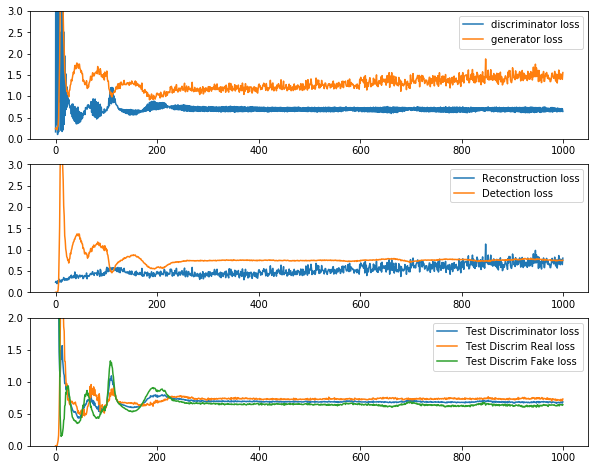

In [15]:
losses=out_dic['losses']
loss_weights=out_dic['weight_hist']
plot_loss(losses,**{'scale_control':[[0,3],[0,3],[0,2]],'loss_weights':loss_weights})

In [16]:
y_hat=Discrim.predict(np.concatenate((x_test,y_test),axis=1))
y_idx = np.argmax(y_hat,axis=1)
print(sum(y_idx==1)/y_idx.shape[0])

0.46025641025641023


In [16]:
min(losses['g'][:,1])


0.03377188

In [17]:
losses['d']

array([ 0.16282016, 12.2134075 ,  0.33470386, 10.84661   ,  0.10161928,
        7.451304  ,  0.16038015,  3.9584773 ,  0.87542504,  1.0650241 ,
        2.4973555 ,  0.1959655 ,  3.3994088 ,  0.17254755,  3.0556598 ,
        0.21008202,  2.509773  ,  0.3399335 ,  1.9481248 ,  0.54848886,
        1.5258155 ,  0.68922085,  1.2222258 ,  0.745874  ,  0.9684158 ,
        0.8317716 ,  0.92042845,  0.79817516,  0.77172166,  0.71820533,
        0.7655276 ,  0.5822258 ,  0.80951715,  0.5127219 ,  0.8183569 ,
        0.46613067,  0.7560257 ,  0.42078722,  0.75743616,  0.40491086,
        0.7054367 ,  0.34994972,  0.71854496,  0.35720998,  0.7446114 ,
        0.36978298,  0.642883  ,  0.38186222,  0.6210944 ,  0.40306938,
        0.6143743 ,  0.4533158 ,  0.6033535 ,  0.48628506,  0.5840467 ,
        0.561106  ,  0.649722  ,  0.65724   ,  0.5695957 ,  0.7334058 ,
        0.7256766 ,  0.73544395,  0.6948701 ,  0.7916064 ,  0.7429696 ,
        0.798481  ,  0.7700043 ,  0.7207192 ,  0.7408625 ,  0.71

In [21]:
from fake_financial import make_fake_data
x_fake=make_fake_data(np.concatenate((x_test,y_test),axis=1),idx_test,ds,num_fakes=780,method='hard',var_scale=1)
y_hat=Discrim.predict(x_fake)
y_idx = np.argmax(y_hat,axis=1)
sum(y_idx==1)/y_idx.shape[0]

0.4307692307692308

In [20]:
y_hat

array([[0.5233099 , 0.4766901 ],
       [0.47818777, 0.5218122 ],
       [0.52644485, 0.47355518],
       ...,
       [0.45429745, 0.5457025 ],
       [0.5085494 , 0.4914506 ],
       [0.48553014, 0.51446986]], dtype=float32)

In [21]:
import pandas as pd
i=64
composed_imgs=Generator.predict([x_test,y_test])
idx=np.hstack(('Revenues',cols[0:199]))
orig=np.hstack((y_test[i],x_test[i,:]))
fakes=np.hstack((composed_imgs[i][-1],composed_imgs[i][0:-1]))
#orig[orig!=0]
#pd.DataFrame({'originals':orig[orig!=0],'fakes':fakes[orig!=0]},index=idx[orig!=0])
df=pd.DataFrame({'originals':orig,'fakes':fakes},index=idx)
df[df.originals!=0]

,fakes,originals
Revenues,0.000738,0.000738
Assets,1.286911,1.363987
pAssets,1.017834,1.000000
pCashAndCashEquivalentsAtCarryingValue,0.265956,0.371226
CashAndCashEquivalentsAtCarryingValue,0.285897,0.254667
LiabilitiesAndStockholdersEquity,1.308001,1.363987
pLiabilitiesAndStockholdersEquity,1.026067,1.000000
NetIncomeLoss,0.200731,0.071316
pNetIncomeLoss,0.179337,0.395014
pStockholdersEquity,0.904508,0.852010


In [15]:
np.random.binomial(1,0.9,size=(10))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])